<center><h1><b><span style="color:blue">Files, data, event processing</span></b></h1></center>

#### **Quick intro to the following packages**
- `uproot` - ROOT I/O in pure Python and NumPy.
- `awkward-array` - manipulate arrays of complex data structures as easily as NumPy.

&nbsp;
<center>
    <img src="images/logo_uproot.png" style="width:150px;"/>
    <h2><b><span style="color:green">ROOT I/O in pure Python and NumPy</span></b></h2>
</center>

### **What is ``uproot``?**

<span style="color:green">**Effectively what connects HEP data (ROOT format) with the Python scientific ecosystem around NumPy!**</span>

`uproot` provides very fast, efficient, and convenient access to ROOT trees.

- Pure Python + NumPy implementation of ROOT I/O.
- An array-centric view of ROOT TTree data:
  - Branches of simple types are simple arrays.
  - Branches of complex types are “jagged arrays”.
-  High performance for large baskets, despite Python’s slowness (because all per-entry operations are performed in NumPy).
- Greatest benefits: simplicity, minimal installation, set-up, and affinity with machine learning interfaces.

### **Why does it exist?**
1. To extract columnar data (branches) from a ROOT file without invoking the
event-handling infrastructure of the ROOT framework.
3. To express the semantics and conventions of the ROOT file format independently
of ROOT, in lieu of a formal specification.

### **Why Python + NumPy?**
- As stressed several times, the scientific Python ecosystem, including much of ML, is designed around a fundamental abstraction called the NumPy array.
- Working with computer scientists is easier when you can say, "*pip install uproot*".
- Implemented correctly, Python + NumPy doesn't have to be slow.
  - Finding the columnar data in a ROOT file may be done in slow Python, as long as
decompression and array manipulations are done by compiled code, see the now-old-ish performance study below.

<center><img src="images/Scikit-HEP_uproot_performance.png" width = "60%"/></center>

### **1. Getting data from a simple ROOT TTree**

By "simple" we mean a file without *jagged structures*, or nested structures with branch sizes depending on an event-by-event basis.

In [1]:
import uproot

In [2]:
f = uproot.open('data/Zmumu.root')

f

<ROOTDirectory b'Zmumu.root' at 0x02e3eb343488>

ROOT files, directories, and trees are like Python dicts with keys() and values().

In [3]:
f.keys()

[b'events;1']

In [4]:
t = f[b'events']
t.keys()

[b'Type',
 b'Run',
 b'Event',
 b'E1',
 b'px1',
 b'py1',
 b'pz1',
 b'pt1',
 b'eta1',
 b'phi1',
 b'Q1',
 b'E2',
 b'px2',
 b'py2',
 b'pz2',
 b'pt2',
 b'eta2',
 b'phi2',
 b'Q2',
 b'M']

In [5]:
t['M']

<TBranch b'M' at 0x02e3eb2cd308>

Uproot's main purpose is to read branches from ROOT files as NumPy arrays:

In [6]:
t['M'].array()

array([82.46269156, 83.62620401, 83.30846467, ..., 95.96547966,
       96.49594381, 96.65672765])

All branches can be looked at with `t.arrays()`. A subset is specified e.g. as `t.arrays(['Run', 'Event'])`:

In [7]:
t.arrays()

{b'Type': <ObjectArray [b'GT' b'TT' b'GT' ... b'TT' b'GT' b'GG'] at 0x02e3eb34dc08>,
 b'Run': array([148031, 148031, 148031, ..., 148029, 148029, 148029]),
 b'Event': array([10507008, 10507008, 10507008, ..., 99991333, 99991333, 99991333]),
 b'E1': array([82.20186639, 62.34492895, 62.34492895, ..., 81.27013558,
        81.27013558, 81.56621735]),
 b'px1': array([-41.19528764,  35.11804977,  35.11804977, ...,  32.37749196,
         32.37749196,  32.48539387]),
 b'py1': array([ 17.4332439 , -16.57036233, -16.57036233, ...,   1.19940578,
          1.19940578,   1.2013503 ]),
 b'pz1': array([-68.96496181, -48.77524654, -48.77524654, ..., -74.53243061,
        -74.53243061, -74.80837247]),
 b'pt1': array([44.7322, 38.8311, 38.8311, ..., 32.3997, 32.3997, 32.3997]),
 b'eta1': array([-1.21769, -1.05139, -1.05139, ..., -1.57044, -1.57044, -1.57044]),
 b'phi1': array([ 2.74126  , -0.440873 , -0.440873 , ...,  0.0370275,  0.0370275,
         0.0370275]),
 b'Q1': array([ 1, -1, -1, ...,  1,  1,  

One can now start performing calculations such as the below. But this is not necessary the best way, think NumPy type of operations ;-).

In [8]:
import numpy

for px,py,pz in t.iterate(["px1","py1","pz1"], outputtype=tuple):
    pt = numpy.sqrt(px**2 + py**2)
    eta = numpy.arctanh(pz / numpy.sqrt(px**2 + py**2 + pz**2))
    phi = numpy.arctan2(py, px)
    print(pt)
    print(eta)
    print(phi)

[44.7322 38.8311 38.8311 ... 32.3997 32.3997 32.5076]
[-1.21769 -1.05139 -1.05139 ... -1.57044 -1.57044 -1.57078]
[ 2.74126   -0.440873  -0.440873  ...  0.0370275  0.0370275  0.0369644]


**Create a Pandas DataFrame**

In [9]:
import pandas

df = t.pandas.df()
df

,Type,Run,Event,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,Q2,M
entry,,,,,,,,,,,,,,,,,,,,
0,b'GT',148031,10507008,82.201866,-41.195288,17.433244,-68.964962,44.7322,-1.217690,2.741260,1,60.621875,34.144437,-16.119525,-47.426984,38.8311,-1.051390,-0.440873,-1,82.462692
1,b'TT',148031,10507008,62.344929,35.118050,-16.570362,-48.775247,38.8311,-1.051390,-0.440873,-1,82.201866,-41.195288,17.433244,-68.964962,44.7322,-1.217690,2.741260,1,83.626204
2,b'GT',148031,10507008,62.344929,35.118050,-16.570362,-48.775247,38.8311,-1.051390,-0.440873,-1,81.582778,-40.883323,17.299297,-68.447255,44.7322,-1.217690,2.741260,1,83.308465
3,b'GG',148031,10507008,60.621875,34.144437,-16.119525,-47.426984,38.8311,-1.051390,-0.440873,-1,81.582778,-40.883323,17.299297,-68.447255,44.7322,-1.217690,2.741260,1,82.149373
4,b'GT',148031,105238546,41.826389,22.783582,15.036444,-31.689894,27.2981,-0.990688,0.583351,1,49.760726,-20.177373,-9.354149,44.513955,21.8913,1.444340,-2.707650,-1,90.469123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2299,b'GG',148029,99768888,32.701650,19.054651,14.833954,22.051323,24.1264,0.818806,0.661492,1,27.714554,-16.874052,-15.319644,-15.768964,22.8145,-0.645971,-2.404430,-1,60.047138
2300,b'GT',148029,99991333,168.780121,-68.041915,-26.105847,-152.235018,72.8781,-1.482700,-2.775240,-1,81.566217,32.485394,1.201350,-74.808372,32.3997,-1.570440,0.037027,1,96.125376
2301,b'TT',148029,99991333,81.270136,32.377492,1.199406,-74.532431,32.3997,-1.570440,0.037027,1,168.780121,-68.041915,-26.105847,-152.235018,72.8781,-1.482700,-2.775240,-1,95.965480


In [10]:
t.pandas.df(['Run', 'Event', 'pt1', 'pt2']).head()

,Run,Event,pt1,pt2
entry,,,,
0,148031,10507008,44.7322,38.8311
1,148031,10507008,38.8311,44.7322
2,148031,10507008,38.8311,44.7322
3,148031,10507008,38.8311,44.7322
4,148031,105238546,27.2981,21.8913


### **2. Data with jagged structure**

In [11]:
f = uproot.open('data/uproot-tutorial-file.root')

f.keys()

[b'Events;1']

In [12]:
branches = f[b'Events'].arrays(namedecode='utf-8')
                               
branches

{'nMuon': array([2, 2, 1, ..., 3, 2, 3], dtype=uint32),
 'Muon_pt': <JaggedArray [[10.763697 15.736523] [10.53849 16.327097] [3.2753265] ... [6.343258 6.9803934 5.0852466] [3.3099499 15.68049] [11.444268 3.082721 4.9692106]] at 0x02e3ebfc2108>,
 'Muon_eta': <JaggedArray [[1.0668273 -0.5637865] [-0.42778006 0.34922507] [2.2108555] ... [-0.59949154 -0.0495256 -0.9052992] [1.6359439 0.4766063] [0.44437575 -1.6943384 0.7640488]] at 0x02e3ec0581c8>,
 'Muon_phi': <JaggedArray [[-0.034272723 2.5426154] [-0.2747921 2.5397813] [-1.2234136] ... [-2.9530895 0.26560423 -3.1138406] [0.87988055 -1.7524908] [-0.47927496 2.2850282 0.5623152]] at 0x02e3ec058248>,
 'Muon_mass': <JaggedArray [[0.10565837 0.10565837] [0.10565837 0.10565837] [0.10565837] ... [0.10565837 0.10565837 0.10565837] [0.10565837 0.10565837] [0.10565837 0.10565837 0.10565837]] at 0x02e3ec058288>,
 'Muon_charge': <JaggedArray [[-1 -1] [1 -1] [1] ... [-1 1 1] [1 -1] [1 -1 1]] at 0x02e3ec0582c8>}

The jagged structure here comes from the number of muons per event, which is variable:

In [13]:
branches['nMuon']

array([2, 2, 1, ..., 3, 2, 3], dtype=uint32)

This becomes evident when checking for example the $p_T$ of all muons:

In [14]:
branches['Muon_pt']

<JaggedArray [[10.763697 15.736523] [10.53849 16.327097] [3.2753265] ... [6.343258 6.9803934 5.0852466] [3.3099499 15.68049] [11.444268 3.082721 4.9692106]] at 0x02e3ebfc2108>

Print the $p_T$ for the muons in the first 10 events to trivially see the jagged structure:

In [15]:
print(' \n'.join([str(elm) for elm in branches['Muon_pt'][:10]]))

[10.763697 15.736523] 
[10.53849  16.327097] 
[3.2753265] 
[11.429154  17.634033   9.624728   3.5022252] 
[ 3.2834418  3.6440058 32.911224  23.721754 ] 
[3.566528 4.572504 4.371863] 
[57.6067  53.04508] 
[11.319675 23.906353] 
[10.193569 14.204061] 
[11.470704   3.4690065]


We will get back to jagged arrays in a sec. Let's first show that `uproot` also has (limited) writing functionality.

### **3. Interoperability - writing files with uproot**

`uproot` version 3 started support for writing files!

In [16]:
f = uproot.recreate("tmp.root")

In [17]:
f["name"] = numpy.histogram(numpy.random.normal(0, 1, 100000), bins=20)

In [18]:
f.closed

False

In [19]:
f.keys()

[b'name;1']

In [20]:
ar = f["name"]

ar.show()

                           0                                               18257
                           +---------------------------------------------------+
[-inf, -4.8553)      0     |                                                   |
[-4.8553, -4.411)    1     |                                                   |
[-4.411, -3.9667)    6     |                                                   |
[-3.9667, -3.5224)   18    |                                                   |
[-3.5224, -3.0782)   94    |                                                   |
[-3.0782, -2.6339)   294   |*                                                  |
[-2.6339, -2.1896)   997   |***                                                |
[-2.1896, -1.7453)   2607  |*******                                            |
[-1.7453, -1.301)    5634  |****************                                   |
[-1.301, -0.85676)   9811  |***************************                        |
[-0.85676, -0.41247) 14276 |

But ... can the file actually be read back in ROOT ...? (Yes it can!)

If you have ROOT installed, try
```python
import ROOT

f = ROOT.TFile("tmp.root")
h = f.Get("name")

c = ROOT.TCanvas("myCanvasName","The Canvas Title",800,600)
h.Draw('hist')
c.Draw()
```

If not, and you aren't working in Windows, try to install ROOT via Conda,
```python
!conda install root -c conda-forge -y
```
and then try the above.

&nbsp;<br><center><img src="images/logo_awkward-array.png" style="width: 150px;"/></center>

<center><h2><b><span style="color:green">Manipulate arrays of complex data structures as easily as NumPy</span></b></h2></center>

In [21]:
import awkward

In [22]:
branches

{'nMuon': array([2, 2, 1, ..., 3, 2, 3], dtype=uint32),
 'Muon_pt': <JaggedArray [[10.763697 15.736523] [10.53849 16.327097] [3.2753265] ... [6.343258 6.9803934 5.0852466] [3.3099499 15.68049] [11.444268 3.082721 4.9692106]] at 0x02e3ebfc2108>,
 'Muon_eta': <JaggedArray [[1.0668273 -0.5637865] [-0.42778006 0.34922507] [2.2108555] ... [-0.59949154 -0.0495256 -0.9052992] [1.6359439 0.4766063] [0.44437575 -1.6943384 0.7640488]] at 0x02e3ec0581c8>,
 'Muon_phi': <JaggedArray [[-0.034272723 2.5426154] [-0.2747921 2.5397813] [-1.2234136] ... [-2.9530895 0.26560423 -3.1138406] [0.87988055 -1.7524908] [-0.47927496 2.2850282 0.5623152]] at 0x02e3ec058248>,
 'Muon_mass': <JaggedArray [[0.10565837 0.10565837] [0.10565837 0.10565837] [0.10565837] ... [0.10565837 0.10565837 0.10565837] [0.10565837 0.10565837] [0.10565837 0.10565837 0.10565837]] at 0x02e3ec058288>,
 'Muon_charge': <JaggedArray [[-1 -1] [1 -1] [1] ... [-1 1 1] [1 -1] [1 -1 1]] at 0x02e3ec0582c8>}

In [23]:
table = awkward.Table(branches)

table

<Table [<Row 0> <Row 1> <Row 2> ... <Row 99997> <Row 99998> <Row 99999>] at 0x02e3eb5ca3c8>

In [24]:
table.nMuon[0]

2

In [25]:
branches['nMuon'][0]

2

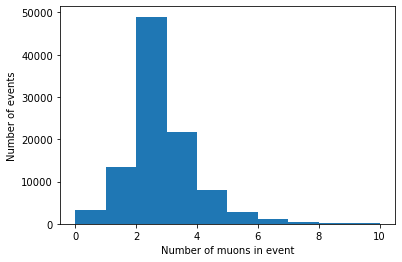

In [26]:
import matplotlib.pyplot as plt

plt.hist(table.nMuon, bins=10, range=(0, 10))
plt.xlabel('Number of muons in event')
plt.ylabel('Number of events');

How many muon entries are there in total?

In [27]:
branches['nMuon'].sum()

235286

In [28]:
len(branches['Muon_pt']), len(branches['Muon_pt'].flatten())  # 235286 muons in 1e5 events

(100000, 235286)

Plot the $p_T$ and $\eta$ of all muons:

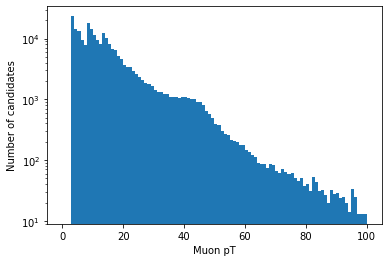

In [29]:
plt.hist(table.Muon_pt.flatten(), bins=100, range=(0, 100))
plt.xlabel('Muon pT')
plt.ylabel('Number of candidates')
plt.yscale('log');

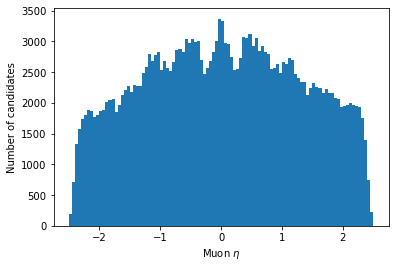

In [30]:
plt.hist(table.Muon_eta.flatten(), bins=100, range=(-2.5, 2.5))
plt.xlabel('Muon $\eta$')
plt.ylabel('Number of candidates');

In [31]:
%%timeit
len(branches['Muon_pt'].flatten())

18.1 µs ± 1.26 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [32]:
%%timeit
branches['nMuon'].sum()

44.9 µs ± 2.56 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Selections are done via masks. Let's create one that singles out events with a single muon:

In [33]:
branches['nMuon'] == 1

array([False, False,  True, ..., False, False, False])

In [34]:
single_muon_mask = branches['nMuon'] == 1
single_muon_mask.sum()

13447

Just checking:

In [35]:
len(branches['Muon_pt'][single_muon_mask]), branches['Muon_pt'][single_muon_mask]

(13447,
 <JaggedArray [[3.2753265] [3.837803] [16.145521] ... [8.18912] [13.272973] [9.484549]] at 0x02e3ed5fed88>)

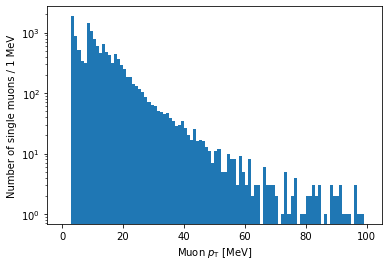

In [36]:
plt.hist(branches['Muon_pt'][single_muon_mask].flatten(), bins=100, range=(0, 100))
plt.xlabel('Muon $p_{\mathrm{T}}$ [MeV]')
plt.ylabel('Number of single muons / 1 MeV')
plt.yscale('log')
plt.show()

Mask to selection muons within $|\eta| <2$:

In [37]:
eta_mask = abs(branches['Muon_eta']) < 2
eta_mask

<JaggedArray [[True True] [True True] [False] ... [True True True] [True True] [True True True]] at 0x02e3ed461288>

In [38]:
eta_mask.flatten().sum()

204564

In [39]:
eta_mask.sum()

array([2, 2, 0, ..., 3, 2, 3], dtype=int32)

In [40]:
eta_mask.sum().sum()

204564

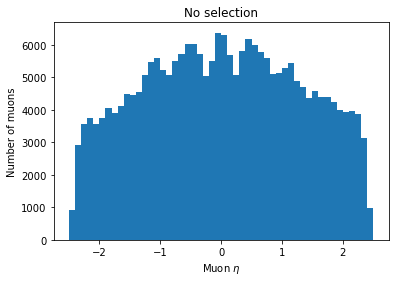

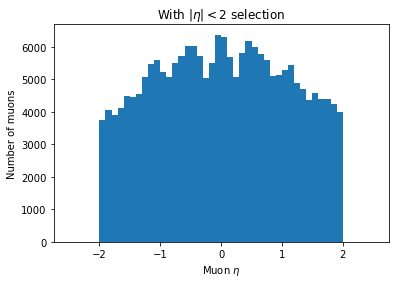

In [41]:
plt.hist(branches['Muon_eta'].flatten(), bins=50, range=(-2.5, 2.5))
plt.title('No selection')
plt.xlabel('Muon $\eta$')
plt.ylabel('Number of muons')
plt.show()

plt.hist(branches['Muon_eta'][eta_mask].flatten(), bins=50, range=(-2.5, 2.5))
plt.title('With $|\eta| < 2$ selection')
plt.xlabel('Muon $\eta$')
plt.ylabel('Number of muons')
plt.show()

In [42]:
len(single_muon_mask & eta_mask)

100000

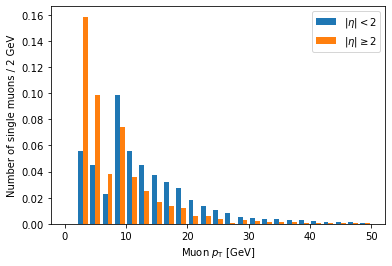

In [43]:
plt.hist([branches['Muon_pt'][single_muon_mask & eta_mask].flatten(),
          branches['Muon_pt'][single_muon_mask & ~eta_mask].flatten()],
         label=['$|\eta| < 2$', '$|\eta| \geq 2$'],
         density=True,
         bins=25, range=(0, 50))
plt.xlabel('Muon $p_{\mathrm{T}}$ [GeV]')
plt.ylabel('Number of single muons / 2 GeV')
plt.legend()
plt.show()

Concentrate on 2-muon events:

In [44]:
two_muons_mask = branches['nMuon'] == 2
two_muons_table = table[two_muons_mask]

In [45]:
# Better methods to deal with Lorentz vectors are soon to be available

import uproot_methods

two_muons_p4 = uproot_methods.TLorentzVectorArray.from_ptetaphim(two_muons_table['Muon_pt'],
                                                                 two_muons_table['Muon_eta'],
                                                                 two_muons_table['Muon_phi'],
                                                                 two_muons_table['Muon_mass'])
two_muons_p4

<JaggedArrayMethods [[PtEtaPhiMassLorentzVector(pt=10.764, eta=1.0668, phi=-0.034273, mass=0.10566) PtEtaPhiMassLorentzVector(pt=15.737, eta=-0.56379, phi=2.5426, mass=0.10566)] [PtEtaPhiMassLorentzVector(pt=10.538, eta=-0.42778, phi=-0.27479, mass=0.10566) PtEtaPhiMassLorentzVector(pt=16.327, eta=0.34923, phi=2.5398, mass=0.10566)] [PtEtaPhiMassLorentzVector(pt=57.607, eta=-0.53209, phi=-0.071798, mass=0.10566) PtEtaPhiMassLorentzVector(pt=53.045, eta=-1.0042, phi=3.0895, mass=0.10566)] ... [PtEtaPhiMassLorentzVector(pt=9.5837, eta=-1.5126, phi=-0.22681, mass=0.10566) PtEtaPhiMassLorentzVector(pt=3.3317, eta=2.1995, phi=-2.7097, mass=0.10566)] [PtEtaPhiMassLorentzVector(pt=46.362, eta=-1.9284, phi=-2.3773, mass=0.10566) PtEtaPhiMassLorentzVector(pt=43.904, eta=-2.2734, phi=0.86049, mass=0.10566)] [PtEtaPhiMassLorentzVector(pt=3.3099, eta=1.6359, phi=0.87988, mass=0.10566) PtEtaPhiMassLorentzVector(pt=15.68, eta=0.47661, phi=-1.7525, mass=0.10566)]] at 0x02e3ed2fdc08>

In [46]:
len(two_muons_p4)

48976

In [47]:
first_muon_p4 = two_muons_p4[:, 0]
second_muon_p4 = two_muons_p4[:, 1]

In [48]:
first_muon_p4.delta_r(second_muon_p4)

array([3.0494678, 2.9198563, 3.1573637, ..., 4.465935 , 3.0649128,
       2.876359 ], dtype=float32)

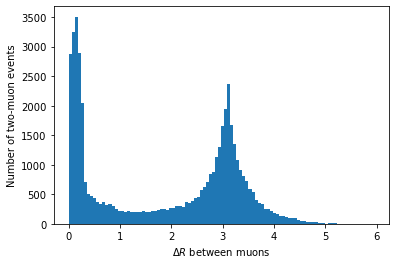

In [49]:
plt.hist(first_muon_p4.delta_r(second_muon_p4), bins=100)
plt.xlabel('$\Delta R$ between muons')
plt.ylabel('Number of two-muon events')
plt.show()

Further refine to $\mu^+\mu^-$ pairs - you see where're getting ;-):

In [50]:
sum_p4 = first_muon_p4 + second_muon_p4
opposite_sign_muons_mask = two_muons_table['Muon_charge'][:, 0] != two_muons_table['Muon_charge'][:, 1]
dimuon_p4 = sum_p4[opposite_sign_muons_mask]
dimuon_p4

<TLorentzVectorArray [TLorentzVector(x=-3.3155, y=6.3838, z=1.1715, t=28.851) TLorentzVector(x=4.4851, y=-1.3713, z=-94.799, t=148.07) TLorentzVector(x=-20.767, y=-28.434, z=-27.793, t=44.886) ... TLorentzVector(x=-10.946, y=28.573, z=234.5, t=254.62) TLorentzVector(x=-4.838, y=1.2011, z=-367.02, t=378.28) TLorentzVector(x=-0.72416, y=-12.872, z=15.934, t=26.316)] at 0x02e3ed4e8088>

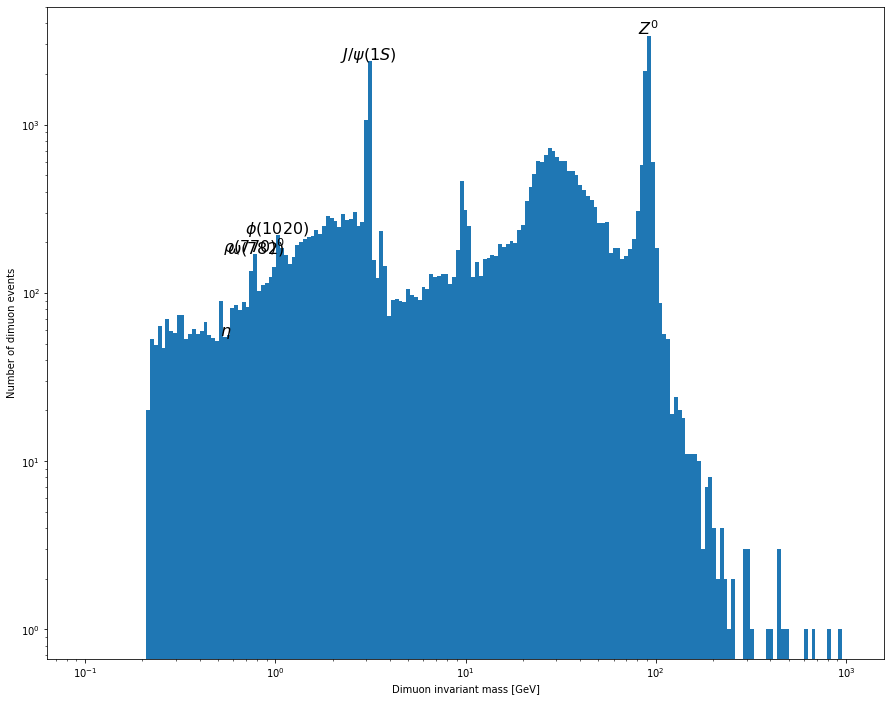

In [51]:
import numpy as np

figsize_l, figsize_h = plt.rcParams["figure.figsize"]
plt.figure(figsize=(figsize_l*2.5, figsize_h*3.))

(yvals, binedges, patches) = plt.hist(dimuon_p4.mass, bins=np.logspace(np.log10(0.1), np.log10(1000), 200))

plt.xlabel('Dimuon invariant mass [GeV]')
plt.ylabel('Number of dimuon events')
plt.xscale('log')
plt.yscale('log')

import particle.particle.literals as lpart
from hepunits import GeV
    
list_particles = [getattr(lpart,name) for name in ('eta', 'rho_770_0', 'omega_782','phi_1020','Jpsi_1S', 'Z_0')]

for p in list_particles:
    binnumber = np.searchsorted(binedges, p.mass/GeV)
    plt.text(p.mass/GeV, yvals[binnumber-1]*1.02, '${}$'.format(p.latex_name), horizontalalignment='center', fontsize=16)

plt.show()

&nbsp;
<div class="alert alert-warning">

<b>Important note:</b>

These 2 packages are currently under a major overhaul!
</div>

- `awkward-array` is being replaced by an improved package nicknamed `awkward-1.0` for now. Developments are happening at [this GitHub repository](https://github.com/scikit-hep/awkward-1.0).
- `uproot` version 4 will be the upgrade version of `uproot` version 3 built atop `awkward-1.0`, see https://github.com/scikit-hep/uproot4.